# The Catalog Object

In this tutorial, we will:
- explore the purpose and scope of the `Catalog` object in an LSDB pipeline
- load catalogs in LSDB and inspect their metadata

## Introduction

The `Catalog` object encapsulates all of the information that LSDB knows about an astronomical catalog, and is the basis for performing operations on the underlying catalog data.

There are two types of catalog data that the `Catalog` object exposes:
1. high-level metadata: The columns and table schema of the catalog, the number of partitions of data, sky coverage, provenance information, basic aggregate statistics about the data.
1. leaf-level tabular data: the full rows of data from the objects and/or observations in the catalog.


## 1. Getting Data into LSDB

The simplest way to load a catalog in LSDB is to call `lsdb.open_catalog()` with a path to a catalog in the HATS format. This will return a `Catalog` object with all the high level metadata loaded that LSDB needs to enable you to work with the catalog. We recommend you to visit our website, [data.lsdb.io](https://data.lsdb.io), where you are able to find large surveys in HATS format publicly available to use. If you're looking for how to get your own external data into LSDB, see the topic [Import Catalogs](import_catalogs.html) instead.

Let's open GAIA DR3 as an example and take a look at the object we get back.

In [6]:
import lsdb

In [7]:
gaia_path = "https://data.lsdb.io/hats/gaia_dr3"
gaia = lsdb.open_catalog(gaia_path)
gaia

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
npartitions=2016,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 2, Pixel: 0",int64[pyarrow],string[pyarrow],int64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int8[pyarrow],bool[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int16[pyarrow],int16[pyarrow],float[pyarrow],int16[pyarrow],int16[pyarrow],int16[pyarrow],float[pyarrow],float[pyarrow],int8[pyarrow],int8[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],bool[pyarrow],int16[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int16[pyar

The Gaia catalog is very wide so you would be requesting its whole set of >150 columns. We can see all of the columns available in the catalog by using the `all_columns` property.

In [8]:
gaia.all_columns[:10]  # Truncating the output to not display the whole list

['solution_id',
 'designation',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax']

Note that it's important (and highly recommended) to:

- **Pre-select a small subset of columns** that satisfies your scientific needs. Loading an unnecessarily large amount of data leads to computationally expensive and inefficient workflows. To see which columns are available, use the `catalog.all_columns` property, then load the catalog with only the necesarry columns.

- **Load catalogs with their respective margin caches**, when available. These margins are necessary to obtain accurate results in several operations such as joining and crossmatching. If you're working with catalogs from [data.lsdb.io](https://data.lsdb.io), the margin cache will be included in the `open_catalog()` call for you to copy if it is available. For more information about margins please visit our [Margins](margins.ipynb) topic notebook.

Let's define the set of columns we need and add the margin catalog's path to our `open_catalog` call.

In [9]:
gaia = lsdb.open_catalog(
    "https://data.lsdb.io/hats/gaia_dr3/",
    columns=[
        "source_id",
        "ra",
        "dec",
        "phot_g_mean_mag",
        "phot_proc_mode",
        "azero_gspphot",
        "classprob_dsc_combmod_star",
    ],
)
gaia

,source_id,ra,dec,phot_g_mean_mag,phot_proc_mode,azero_gspphot,classprob_dsc_combmod_star
npartitions=2016,,,,,,,
"Order: 2, Pixel: 0",int64[pyarrow],double[pyarrow],double[pyarrow],float[pyarrow],int8[pyarrow],float[pyarrow],float[pyarrow]
"Order: 2, Pixel: 1",...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
"Order: 3, Pixel: 766",...,...,...,...,...,...,...
"Order: 3, Pixel: 767",...,...,...,...,...,...,...


When we look at the catalog's representation above, we can see all the columns that are in the catalog object along with their datatypes, and information about how HATS has partitioned the catalog. But there's one thing that we can't see: we haven't loaded any of the data yet! That's why we have the `...` as placeholders for the data, and the warning at the bottom. This is because LSDB's operations are what we call *lazy*: they don't actually perform any work on the data when you call them, they just plan out the pipeline of operations to be performed later. This is how LSDB can work on huge catalogs with billions of rows, and run on any scale of device from a laptop up to a supercomputer. To learn more about how Lazy operations work, take a look at our [lazy operations tutorial.](lazy_operations.html)

## 2. Inspecting the Catalog metadata

The natural next step once you have a catalog object is to explore the metadata that has been loaded to understand what kind of data is inside your catalog.

First, we will generate a basic plot showing the sky coverage of the catalog. The `Catalog` object's `plot_pixels` method shows a plot of the HATS partitioning of the catalog. GAIA is a survey that covers the whole sky, so we see the whole sky covered in pixels. The colors of the pixels represent the pixel sizes. The main advantage of HATS partitioning is that the partitions all contain roughly the same amount of rows, so the smaller the pixels, the more dense the catalog is in that area. This explains why we see smaller pixels in the galactic bulge.

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel map - gaia'}>)

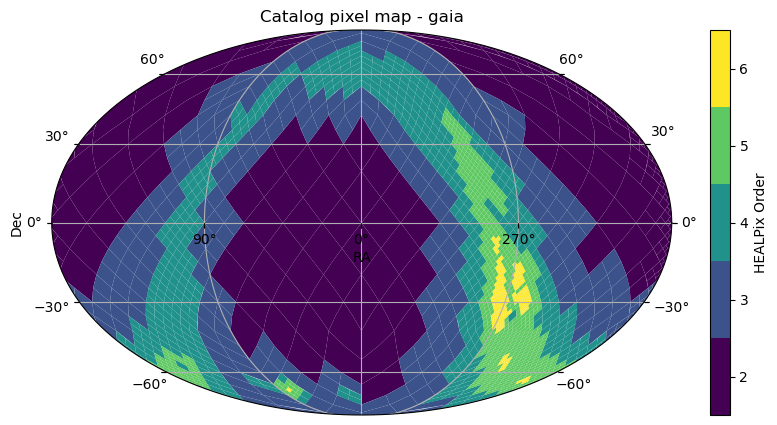

In [10]:
gaia.plot_pixels()

We can also get an idea of the schema of data that's stored in the catalog, by looking at the `columns` and `dtypes`.

In [11]:
gaia.columns

Index(['source_id', 'ra', 'dec', 'phot_g_mean_mag', 'phot_proc_mode',
       'azero_gspphot', 'classprob_dsc_combmod_star'],
      dtype='object')

In [12]:
gaia.dtypes

source_id                      int64[pyarrow]
ra                            double[pyarrow]
dec                           double[pyarrow]
phot_g_mean_mag                float[pyarrow]
phot_proc_mode                  int8[pyarrow]
azero_gspphot                  float[pyarrow]
classprob_dsc_combmod_star     float[pyarrow]
dtype: object

The `columns` method shows the columns that have been loaded, and will be available to any operations on the catalog. You can still see all of the columns in the catalog by calling the `all_columns` method, but to use any of these columns that aren't in the `columns` the catalog will need to be opened again with these columns selected.

In [13]:
gaia.all_columns[:10]  # Truncating the output to not display the whole list

['solution_id',
 'designation',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax']

We can also see how many objects are in the catalog, which is another piece of metadata that is loaded by `open_catalog`.

In [14]:
len(gaia)

1812731847

## Working with Catalog Data

Now that we have a catalog object, we're ready to start planning and executing operations on the data! Our next tutorials will explain how that works and all the operations you can do with LSDB.

## About

**Authors**: Sandro Campos, Melissa DeLucchi, and Sean McGuire

**Last updated/verified on**: Jan 19, 2026

If you use `lsdb` for published research, please cite following [instructions](https://docs.lsdb.io/en/stable/citation.html).